# Import Dataset & Libraries

In [2]:
#Import necessary libraries
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
from sklearn.utils import resample
from scipy.stats import skew, kurtosis,stats,mannwhitneyu, ttest_ind, levene, shapiro  #
import statsmodels.stats.api as sms


# from statsmodels.stats.api import proportion_effectsize
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.6f}'.format


In [3]:
#load dataset
treatment = pd.read_csv('test_group.csv', delimiter=';')
control = pd.read_csv('control_group.csv', delimiter=';')

In [4]:
#combine data into 1 dataframe
df = pd.concat([treatment, control])
df.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Test Campaign,1.08.2019,3008,39550.000000,35820.000000,3038.000000,1946.000000,1069.000000,894.000000,255.000000
1,Test Campaign,2.08.2019,2542,100719.000000,91236.000000,4657.000000,2359.000000,1548.000000,879.000000,677.000000
2,Test Campaign,3.08.2019,2365,70263.000000,45198.000000,7885.000000,2572.000000,2367.000000,1268.000000,578.000000
3,Test Campaign,4.08.2019,2710,78451.000000,25937.000000,4216.000000,2216.000000,1437.000000,566.000000,340.000000
4,Test Campaign,5.08.2019,2297,114295.000000,95138.000000,5863.000000,2106.000000,858.000000,956.000000,768.000000


In [5]:
#rename column to simplify work
cols = ['campaign_name','date','spend', 'impression','reach','clicks','searches','view','atc','purchase'] 
df.columns = cols

In [6]:
df['ctr'] = df['clicks']/ df['impression']*100

# Exploratory Data Analysis

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60 entries, 0 to 29
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   campaign_name  60 non-null     object 
 1   date           60 non-null     object 
 2   spend          60 non-null     int64  
 3   impression     59 non-null     float64
 4   reach          59 non-null     float64
 5   clicks         59 non-null     float64
 6   searches       59 non-null     float64
 7   view           59 non-null     float64
 8   atc            59 non-null     float64
 9   purchase       59 non-null     float64
 10  ctr            59 non-null     float64
dtypes: float64(8), int64(1), object(2)
memory usage: 5.6+ KB


In [9]:
df.groupby(['campaign_name']).count()

,date,spend,impression,reach,clicks,searches,view,atc,purchase,ctr
campaign_name,,,,,,,,,,
Control Campaign,30,30,29,29,29,29,29,29,29,29
Test Campaign,30,30,30,30,30,30,30,30,30,30


## Preprocessing data by data imputation

In [11]:
#data imputation
null_cols = df.columns[df.isna().sum() > 0].tolist()
df.fillna(df[null_cols].mean(), inplace=True)
df.isna().sum()

campaign_name    0
date             0
spend            0
impression       0
reach            0
clicks           0
searches         0
view             0
atc              0
purchase         0
ctr              0
dtype: int64

In [12]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
object_cols = df.select_dtypes(exclude='int64').columns

In [13]:
df.describe()

,spend,impression,reach,clicks,searches,view,atc,purchase,ctr
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,2425.750000,91775.881356,70868.644068,5682.593220,2321.813559,1900.169492,1087.220339,522.000000,7.712679
std,381.130461,32188.767138,30759.617620,1739.843010,663.346510,681.414684,426.543859,195.297513,5.581159
min,1757.000000,22521.000000,10598.000000,2277.000000,1001.000000,848.000000,278.000000,222.000000,1.857546
25%,2073.750000,69558.250000,43235.500000,4230.750000,1970.750000,1249.000000,863.250000,340.000000,4.315104
50%,2420.500000,95448.500000,75205.500000,5686.796610,2374.500000,1937.584746,1081.110169,506.000000,6.426811
75%,2727.500000,117160.500000,95314.250000,7201.250000,2755.750000,2422.500000,1384.250000,685.000000,8.437011
max,3112.000000,145248.000000,127852.000000,8264.000000,4891.000000,4219.000000,1913.000000,890.000000,33.821766


In [14]:
#add skewness and kurtosis
stats_table = df.describe().T
stats_table['kurtosis'] = df[numeric_cols].apply(lambda x: x.kurt())
stats_table['skewness'] = df[numeric_cols].apply(lambda x: x.skew())
stats_table

,count,mean,std,min,25%,50%,75%,max,kurtosis,skewness
spend,60.000000,2425.750000,381.130461,1757.000000,2073.750000,2420.500000,2727.500000,3112.000000,-1.101650,-0.012966
impression,60.000000,91775.881356,32188.767138,22521.000000,69558.250000,95448.500000,117160.500000,145248.000000,-0.893116,-0.376773
reach,60.000000,70868.644068,30759.617620,10598.000000,43235.500000,75205.500000,95314.250000,127852.000000,-1.023211,-0.180762
clicks,60.000000,5682.593220,1739.843010,2277.000000,4230.750000,5686.796610,7201.250000,8264.000000,-1.169755,-0.123199
searches,60.000000,2321.813559,663.346510,1001.000000,1970.750000,2374.500000,2755.750000,4891.000000,2.708495,0.628852
view,60.000000,1900.169492,681.414684,848.000000,1249.000000,1937.584746,2422.500000,4219.000000,0.775360,0.612852
atc,60.000000,1087.220339,426.543859,278.000000,863.250000,1081.110169,1384.250000,1913.000000,-0.606313,-0.018858
purchase,60.000000,522.000000,195.297513,222.000000,340.000000,506.000000,685.000000,890.000000,-1.275370,0.077129
ctr,60.000000,7.712679,5.581159,1.857546,4.315104,6.426811,8.437011,33.821766,7.587371,2.373089


#### ✨ What descriptive stats says 📊
<h5> Conclusion from the data : </h5>
<b>
    <ul>
        <li> In general, variables (except ctr) are close to normally distributed.</li>
        <li> Mostly, variable kurtosis are moderately-peak</li>
        <li> Almost no outlier found</li>
        <li> Distribution of reach and impression shows that the campaigns have wide coverage and high exposure </li>
        <li> CTR between 6-7% indicates average or above average ctr which is also good </li>
        <li> CTR is not normally distributed, which is make sense also when some campaigns outperform others </li>
    </ul>

    
</b>

In [16]:
cols = 3
rows = round(len(numeric_cols)/3)
cols,rows

(3, 3)

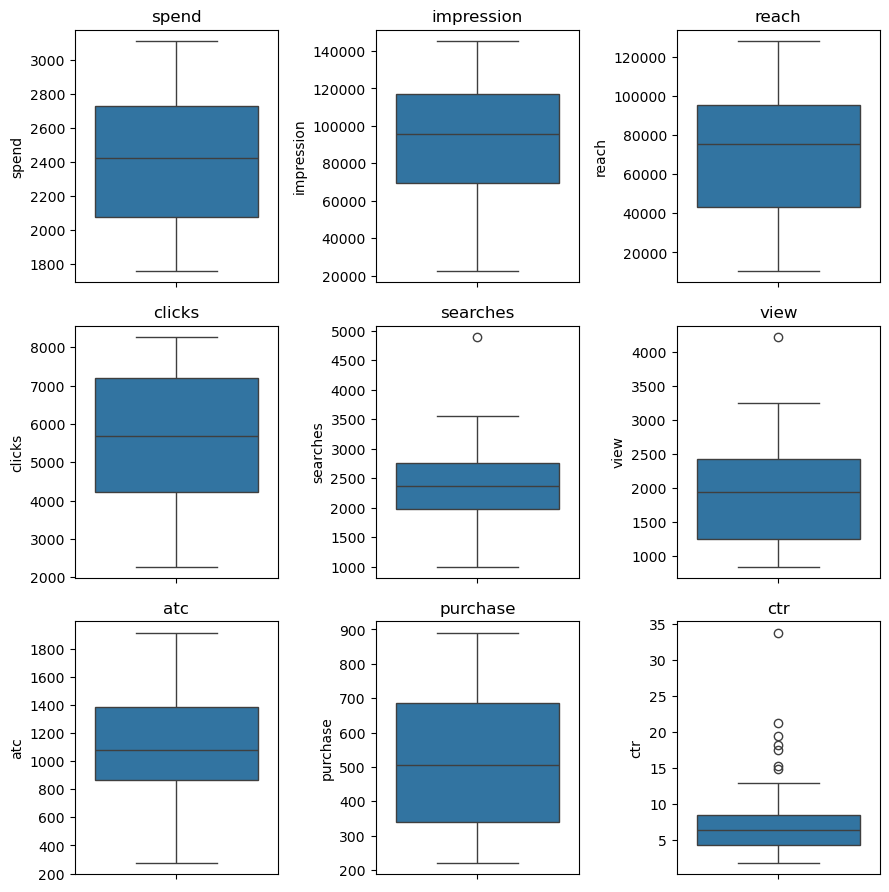

In [17]:
#using boxplot to see the spread of the data through quartiles
fig,axes = plt.subplots(rows,cols, figsize=(3*cols,3*rows))

if len(numeric_cols) == 1:
    axes = [axes]  # Convert single subplot to list
else:
    axes = axes.flatten()

for i, col in enumerate(list(numeric_cols)):
    sns.boxplot(y=df[col], ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

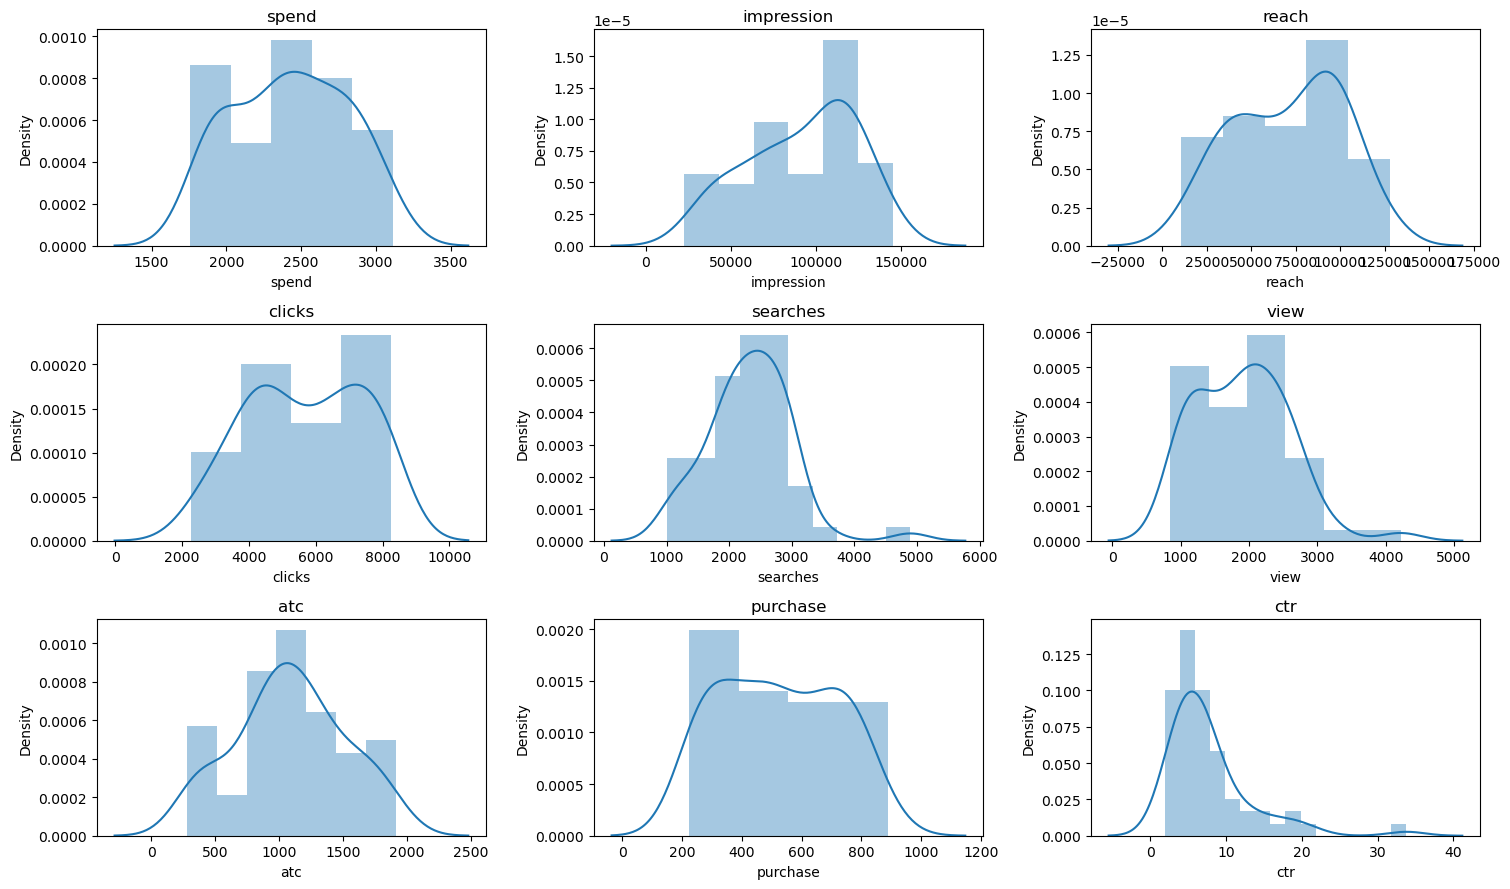

In [18]:
#using boxplot to see the distribution (kurtosis and skewness) of the data 

fig,axes = plt.subplots(rows,cols, figsize=(5*cols,3*rows))

if len(numeric_cols) == 1:
    axes = [axes]  # Convert single subplot to list
else:
    axes = axes.flatten()

for i, col in enumerate(list(numeric_cols)):
    sns.distplot(a=df[col], ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

In [19]:
#compare proportion between groups
version_counts = df.value_counts(subset='campaign_name', normalize=True)
version_counts

campaign_name
Control Campaign   0.500000
Test Campaign      0.500000
Name: proportion, dtype: float64

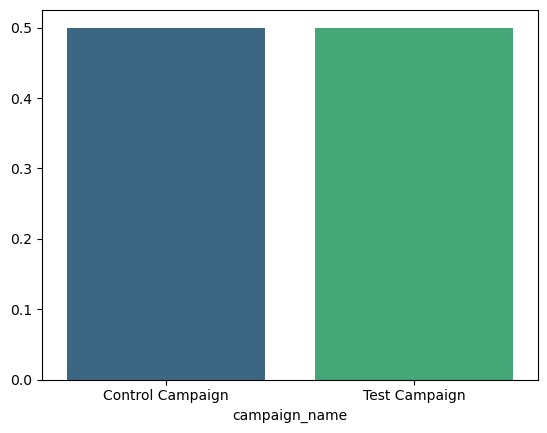

In [20]:
sns.barplot(x=version_counts.index, y=version_counts.values, palette='viridis')
plt.show()

<Axes: >

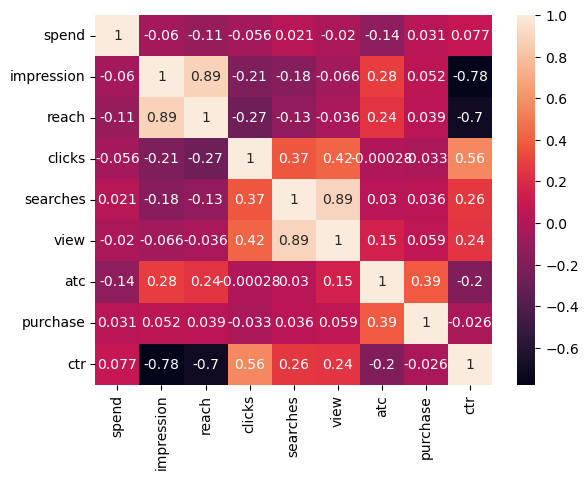

In [21]:
#correlation between variables
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True)

#### ✨ What descriptive stats says 📊
<h5> Conclusion from the data : </h5>
   <p>
     The correlation value between search and view indicate that users used to do search in the first time they open the app. <br>
       Which means <b> THE APP MAY CONFUSING FOR THEM</b>
 </p>

In [23]:
spend_counts = df.groupby(['campaign_name'])['spend'].sum() 
impression_counts = df.groupby(['campaign_name'])['impression'].mean()

reach_counts = df.groupby(['campaign_name'])['reach'].mean()
clicks_counts = df.groupby(['campaign_name'])['clicks'].sum()

search_counts = df.groupby(['campaign_name'])['searches'].sum()
view_counts = df.groupby(['campaign_name'])['view'].sum()

atc_counts = df.groupby(['campaign_name'])['atc'].sum()
purchase_counts = df.groupby(['campaign_name'])['purchase'].sum()

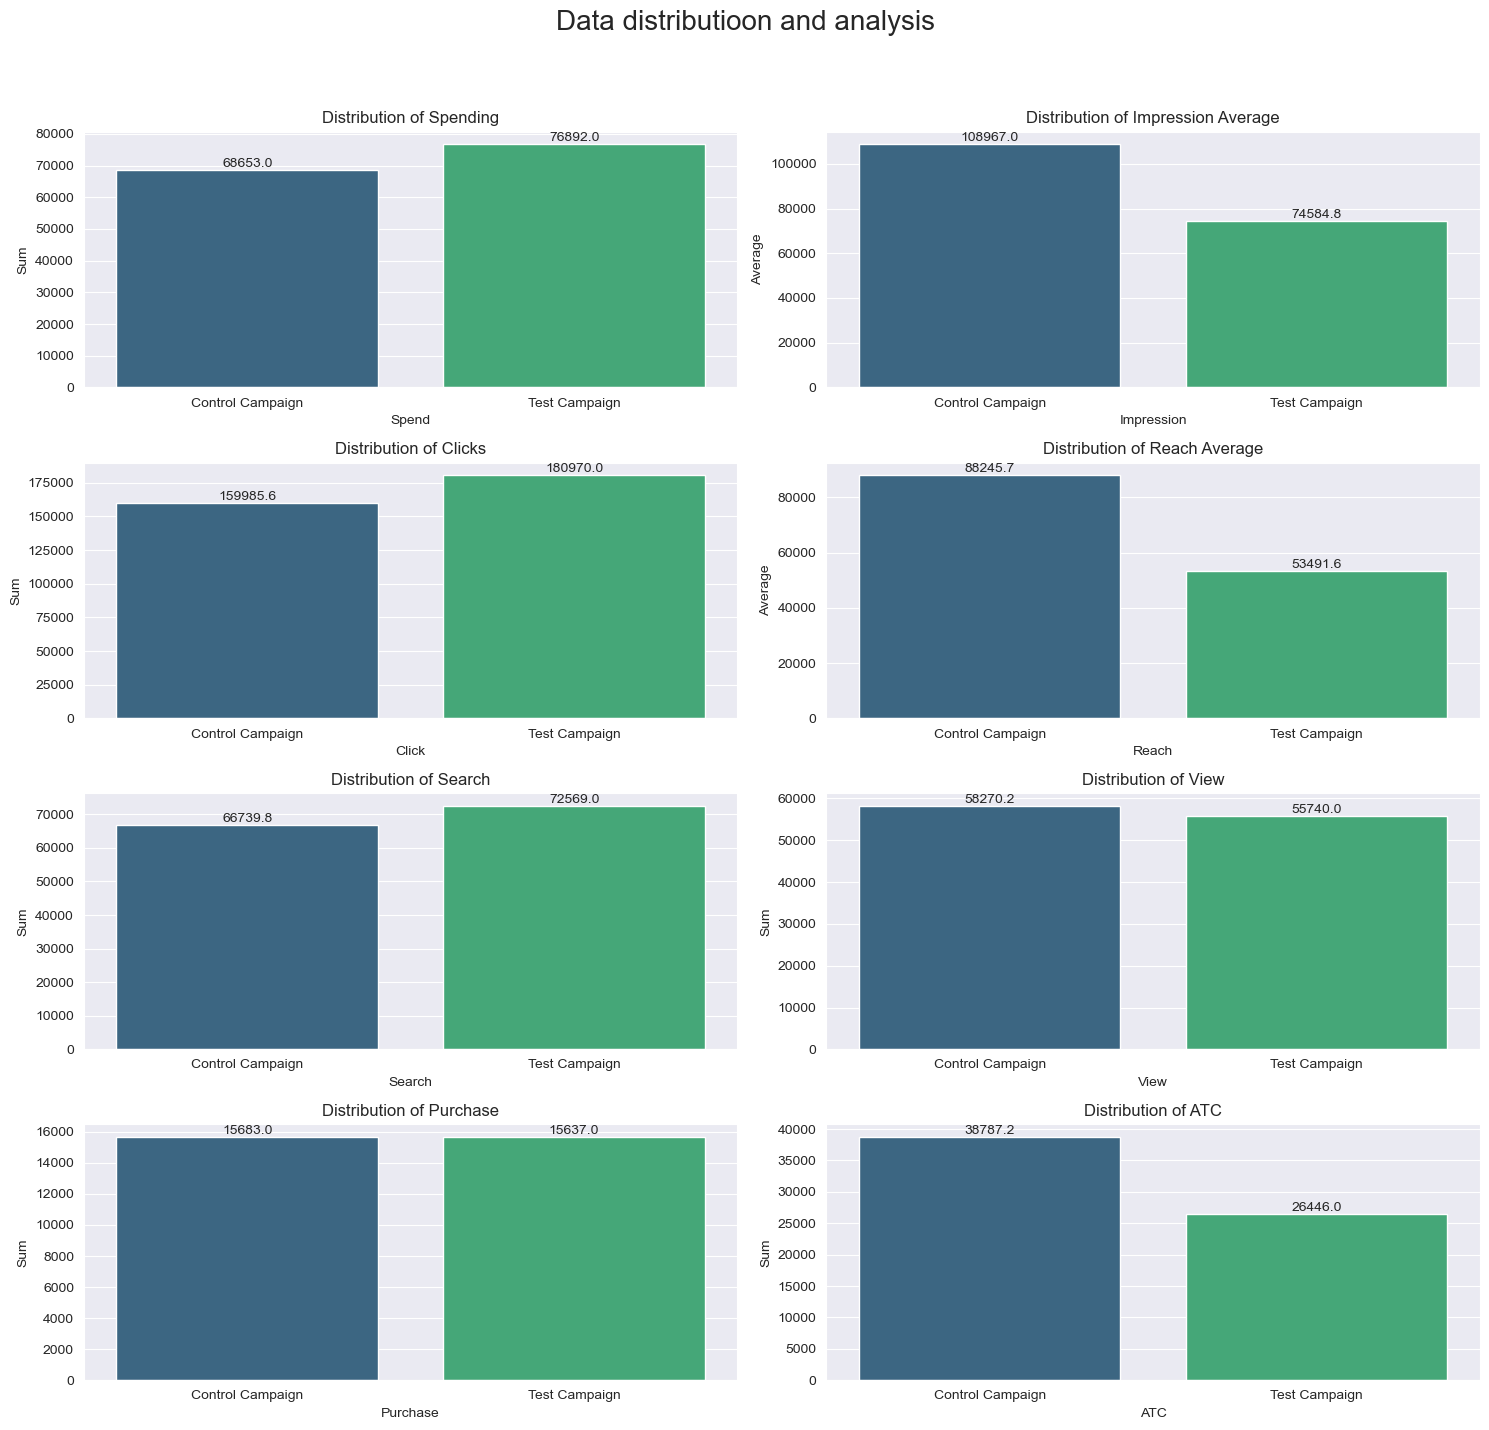

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
fig, axes = plt.subplots(4,2,figsize=(5*cols,5*rows))
fig.suptitle("Data distributioon and analysis", fontsize=20)

# Distribution of the 'spending' column
sns.barplot(x=spend_counts.index, y=spend_counts.values, ax=axes[0, 0], palette='viridis')
axes[0, 0].text(0, spend_counts.values[0] + 1, f'{spend_counts.values[0]:.1f}', ha='center', va='bottom')
axes[0, 0].text(1, spend_counts.values[1] + 1, f'{spend_counts.values[1]:.1f}', ha='center', va='bottom')
axes[0, 0].set_title('Distribution of Spending')
axes[0, 0].set_ylabel('Sum')
axes[0, 0].set_xlabel('Spend')

# Distribution of 'reach'
sns.barplot(x=impression_counts.index, y=impression_counts.values, ax=axes[0, 1], palette='viridis')
axes[0, 1].text(0, impression_counts.values[0] + 1, f'{impression_counts.values[0]:.1f}', ha='center', va='bottom')
axes[0, 1].text(1, impression_counts.values[1] + 1, f'{impression_counts.values[1]:.1f}', ha='center', va='bottom')
axes[0, 1].set_title('Distribution of Impression Average')
axes[0, 1].set_ylabel('Average')
axes[0, 1].set_xlabel('Impression')

# Distribution of 'clicks'
sns.barplot(x=clicks_counts.index, y=clicks_counts.values, ax=axes[1, 0], palette='viridis')
axes[1, 0].text(0, clicks_counts.values[0] + 1, f'{clicks_counts.values[0]:.1f}', ha='center', va='bottom')
axes[1, 0].text(1, clicks_counts.values[1] + 1, f'{clicks_counts.values[1]:.1f}', ha='center', va='bottom')
axes[1, 0].set_title('Distribution of Clicks')
axes[1, 0].set_ylabel('Sum')
axes[1, 0].set_xlabel('Click')


# Distribution of 'reach'
sns.barplot(x=reach_counts.index, y=reach_counts.values, ax=axes[1, 1], palette='viridis')
axes[1, 1].text(0, reach_counts.values[0] + 1, f'{reach_counts.values[0]:.1f}', ha='center', va='bottom')
axes[1, 1].text(1, reach_counts.values[1] + 1, f'{reach_counts.values[1]:.1f}', ha='center', va='bottom')
axes[1, 1].set_title('Distribution of Reach Average')
axes[1, 1].set_ylabel('Average')
axes[1, 1].set_xlabel('Reach')

# # Distribution of 'search_counts'
sns.barplot(x=search_counts.index, y=search_counts.values, ax=axes[2, 0], palette='viridis')
axes[2, 0].text(0, search_counts.values[0] + 1, f'{search_counts.values[0]:.1f}', ha='center', va='bottom')
axes[2, 0].text(1, search_counts.values[1] + 1, f'{search_counts.values[1]:.1f}', ha='center', va='bottom')
axes[2, 0].set_title('Distribution of Search')
axes[2, 0].set_ylabel('Sum')
axes[2, 0].set_xlabel('Search')

# # Distribution of 'view_counts'
sns.barplot(x=view_counts.index, y=view_counts.values, ax=axes[2, 1], palette='viridis')
axes[2, 1].text(0, view_counts.values[0] + 1, f'{view_counts.values[0]:.1f}', ha='center', va='bottom')
axes[2, 1].text(1, view_counts.values[1] + 1, f'{view_counts.values[1]:.1f}', ha='center', va='bottom')
axes[2, 1].set_title('Distribution of View')
axes[2, 1].set_ylabel('Sum')
axes[2, 1].set_xlabel('View')



# # Distribution of 'purchase sum'
sns.barplot(x=purchase_counts.index, y=purchase_counts.values, ax=axes[3, 0], palette='viridis')
axes[3, 0].text(0, purchase_counts.values[0] + 1, f'{purchase_counts.values[0]:.1f}', ha='center', va='bottom')
axes[3, 0].text(1, purchase_counts.values[1] + 1, f'{purchase_counts.values[1]:.1f}', ha='center', va='bottom')
axes[3, 0].set_title('Distribution of Purchase')
axes[3, 0].set_ylabel('Sum')
axes[3, 0].set_xlabel('Purchase')

# # Distribution of 'ATC'
sns.barplot(x=atc_counts.index, y=atc_counts.values, ax=axes[3, 1], palette='viridis')
axes[3, 1].text(0, atc_counts.values[0] + 1, f'{atc_counts.values[0]:.1f}', ha='center', va='bottom')
axes[3, 1].text(1, atc_counts.values[1] + 1, f'{atc_counts.values[1]:.1f}', ha='center', va='bottom')
axes[3, 1].set_title('Distribution of ATC')
axes[3, 1].set_ylabel('Sum')
axes[3, 1].set_xlabel('ATC')


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Preprocessing data by removing outlier

In [26]:
def outlier_remover(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3-q1
    upper_bond = q3 + 1.5 *iqr
    lower_bond = q1 - 1.5 *iqr

    return upper_bond, lower_bond


for i,col in enumerate(numeric_cols):
    upper_bond, lower_bond = outlier_remover(df, col)
    df = df[(df[col] >= lower_bond) & (df[col] <= upper_bond)]

In [27]:
df.shape

(52, 11)

# Statistical Testing

In [29]:
from scipy.stats import mannwhitneyu, ttest_ind, levene, shapiro

**Hypothesis null = There is no difference number of purchase, for treatment campaign compared to control group
<br>
**Hypothesis alternative =  There is significance difference number of purchase, for treatment campaign compared to control group

In [31]:
control_group = df[df['campaign_name']=='Control Campaign']
treatment_group = df[df['campaign_name']=='Test Campaign']

#### Check normality

In [34]:
# control_group = df_clean[df_clean['campaign_name']=='Control Campaign']
# treatment_group = df_clean[df_clean['campaign_name']=='Test Campaign']

In [35]:
shape_control = shapiro(control_group['purchase'])
shape_treatment = shapiro(treatment_group['purchase'])

print(shape_control.pvalue, shape_treatment.pvalue)

0.135035986553729 0.028326636212867615


In [36]:
def print_result(var, p_value):
    if p_value < 0.05:
        print(f"distribution of {var} is not normal : {p_value}")
    else:
        print(f"distribution of {var} is normal : {p_value}")

In [37]:
print_result('Control Group', shape_control.pvalue)
print_result('Treatment Group', shape_treatment.pvalue)

distribution of Control Group is normal : 0.135035986553729
distribution of Treatment Group is not normal : 0.028326636212867615


In [48]:
alpha = 0.05
stat, p_lev = levene(control_group['purchase'], treatment_group['purchase'])
equal_var = p_lev > alpha
print(stat, p_lev, equal_var)

2.2561339050769953 0.1393756268975564 True


In [50]:
#For normal distribution, use T-test statistical method
u_stat, p_value = stats.ttest_ind(control_group['purchase'], treatment_group['purchase'], equal_var = equal_var)
print(f"T-Test: {u_stat:.4f}, P-value: {p_value:.4f}")

T-Test: 0.4201, P-value: 0.6762


In [52]:
#For non normal distribution, use Mann-whitney statistical method

u_stat, p_value = mannwhitneyu(control_group['purchase'], treatment_group['purchase'], alternative='two-sided')
print(f"Mann-Whitney U statistic: {u_stat:.4f}, P-value: {p_value:.4f}")


Mann-Whitney U statistic: 356.0000, P-value: 0.6852


# Conclusion

In [55]:
alpha = 0.05  # 5% significance level
print("Null hypothesis : There is no significant difference on purchase for treatment or control group\n")

if p_value < alpha:
    print("Reject null hypothesis. So, there is a significant difference! ✅")
else:
    print("Fail to reject null hypothesis. So, there's no significant difference. ❌")

Null hypothesis : There is no significant difference on purchase for treatment or control group

Fail to reject null hypothesis. So, there's no significant difference. ❌
